In [1]:
#%pip install tbats

In [2]:
from azureml.core import Workspace, Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
import datetime
from tbats import TBATS
import pickle

# L1-osaston kolmivuorokohtaisen TBATS-mallin koulutus

In [3]:
start = pd.Timestamp('2017-01-01T00')
train_test_8h = pd.Timestamp('2019-01-01')
end = pd.Timestamp('2019-12-31T00')

In [4]:
subscription_id = '4371739e-d07f-42d5-a3a6-efa120c1e246'
resource_group = 'husfd-tu-dip-potilasvirrat'
workspace_name = 'husfd-tu-dip-potilasvirrat-ml'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset_ward = Dataset.get_by_name(workspace, name='uranus27_2')
features_ward = ['henkilotunnus', 'alkuhetki', 'loppuhetki', 'vo_toimipiste_nimi', 'pot_eala_selite', 'paadg_oire_selite', 'mista_lah_tuli_koodi',
       'mista_lah_tuli_nimi', 'mista_tuli_koodi', 'mista_tuli_selite', 'jatkoh_laitos_nimi',
       'jatkoh_toimipiste_nimi', 'jh_koodi', 'jh_selite', 'osastohoito_numero', 'shjakso_numero']
ward = dataset_ward.to_pandas_dataframe()[features_ward]
ward.replace("", float("NaN"), inplace=True)
ward.dropna(subset=['alkuhetki', 'loppuhetki'], inplace=True)
ward.drop_duplicates(subset='osastohoito_numero', inplace=True)
ward = ward[(ward.alkuhetki >= start) & (ward.alkuhetki < end)]
ward_train = ward[ward.alkuhetki < train_test_8h]
ward_test = ward[ward.alkuhetki >= train_test_8h]
ward_train = ward_train.sort_values(by='alkuhetki')

Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'
Failed to extract subscription information, Exception=AttributeError; 'Logger' object has no attribute 'activity_info'


In [5]:
ward_train['alkuhetki'] = pd.to_datetime(ward_train['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train['loppuhetki'] = pd.to_datetime(ward_train['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_train = ward_train[ward_train['alkuhetki'] <= ward_train['loppuhetki']]
ward_train['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_train['alkuhetki'], right = ward_train['loppuhetki'], closed='neither')
ward_train['palveluaika'] = ((ward_train['loppuhetki'] - ward_train['alkuhetki']).astype('timedelta64[s]') / 3600)
print('Keskiarvo:', ward_train.palveluaika.mean())

Keskiarvo: 60.417104122329945


In [6]:
ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")
ward_test = ward_test[ward_test['alkuhetki'] <= ward_test['loppuhetki']]
ward_test['aikaväli'] = pd.arrays.IntervalArray.from_arrays(left = ward_test['alkuhetki'], right = ward_test['loppuhetki'], closed='neither')
ward_test['palveluaika'] = ((ward_test['loppuhetki'] - ward_test['alkuhetki']).astype('timedelta64[s]') / 3600)

/tmp/ipykernel_88515/196084557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['alkuhetki'] = pd.to_datetime(ward_test['alkuhetki'], format="%Y-%m-%d %H:%M:%S")
/tmp/ipykernel_88515/196084557.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ward_test['loppuhetki'] = pd.to_datetime(ward_test['loppuhetki'], format="%Y-%m-%d %H:%M:%S")


In [7]:
aika = start
span_8h = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 17536, 8)]})
timestamp_8h = [aika + timedelta(hours=x) for x in range(0, 17528, 8)] # 730
ward_train_8h = pd.DataFrame(data={'time':timestamp_8h})
ward_train_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h['time'][0:-1], right = span_8h['time'][1:], closed='left')
ward_train_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_8h['timespan']).contains(b) for b in ward_train['alkuhetki']]).sum()
ward_train_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(ward_train_8h['timespan']).contains(b) for b in ward_train['loppuhetki']]).sum()
ward_train_8h.set_index('time', inplace=True)
ward_train_8h.head()

,timespan,arrivals,departments
time,,,
2017-01-01 00:00:00,"[2017-01-01, 2017-01-01 08:00:00)",2,0
2017-01-01 08:00:00,"[2017-01-01 08:00:00, 2017-01-01 16:00:00)",1,0
2017-01-01 16:00:00,"[2017-01-01 16:00:00, 2017-01-02)",2,0
2017-01-02 00:00:00,"[2017-01-02, 2017-01-02 08:00:00)",2,0
2017-01-02 08:00:00,"[2017-01-02 08:00:00, 2017-01-02 16:00:00)",2,0


In [8]:
aika = start
span_8h = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 21152, 8)]}) 
timestamp_8h = [aika + timedelta(hours=x) for x in range(0, 21144, 8)] 
ward_8h = pd.DataFrame(data={'time':timestamp_8h})
ward_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h['time'][0:-1], right = span_8h['time'][1:], closed='left')
ward_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_8h['timespan']).contains(b) for b in ward['alkuhetki']]).sum()
ward_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(ward_8h['timespan']).contains(b) for b in ward['loppuhetki']]).sum()
ward_8h.set_index('time', inplace=True)

In [9]:
aika = train_test_8h
span_8h_test = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 3632, 8)]})
timestamp_8h_test = [aika + timedelta(hours=x) for x in range(0, 3624, 8)]
ward_test_8h = pd.DataFrame(data={'time':timestamp_8h_test})
ward_test_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_8h_test['time'][0:-1], right = span_8h_test['time'][1:], closed='left')
ward_test_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_8h['timespan']).contains(b) for b in ward_test['alkuhetki']]).sum()
ward_test_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(ward_test_8h['timespan']).contains(b) for b in ward_test['loppuhetki']]).sum()
ward_test_8h.set_index('time', inplace=True)

### TBATS

In [10]:
#tbats = TBATS(seasonal_periods=[3, 21, 1095])
#tbats = tbats.fit(ward_train_8h.arrivals)
tbats = pickle.load(open('tbats_L1_2017-2019-triple_final.pkl', 'rb'))
print(tbats.summary())

new_index = pd.date_range("2019-01-01", "2019-06-01", freq="8H")
additive = pd.DataFrame(np.nan, index=new_index[:-1], columns=ward_train_8h.columns)
additive.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
additive['ennuste_TBATS'] = tbats.forecast(steps=453) 

Use Box-Cox: False
Use trend: False
Use damped trend: False
Seasonal periods: [   3.   21. 1095.]
Seasonal harmonics [1 6 1]
ARMA errors (p, q): (1, 0)
Smoothing (Alpha): 0.015385
Seasonal Parameters (Gamma): [-0.00078758 -0.00231797 -0.00031392  0.00105909  0.00324934  0.00086874]
AR coefficients [0.00105909]
MA coefficients []
Seed vector [ 1.65452053 -0.37211107 -0.74600589 -0.18412691 -0.163769    0.01821788
 -0.02089949  0.09908486  0.08330107  0.1998558   0.00497249 -0.0258271
  0.00941786 -0.05289033  0.05450093  0.33360185  0.1864151   0.        ]

AIC 18403.734868


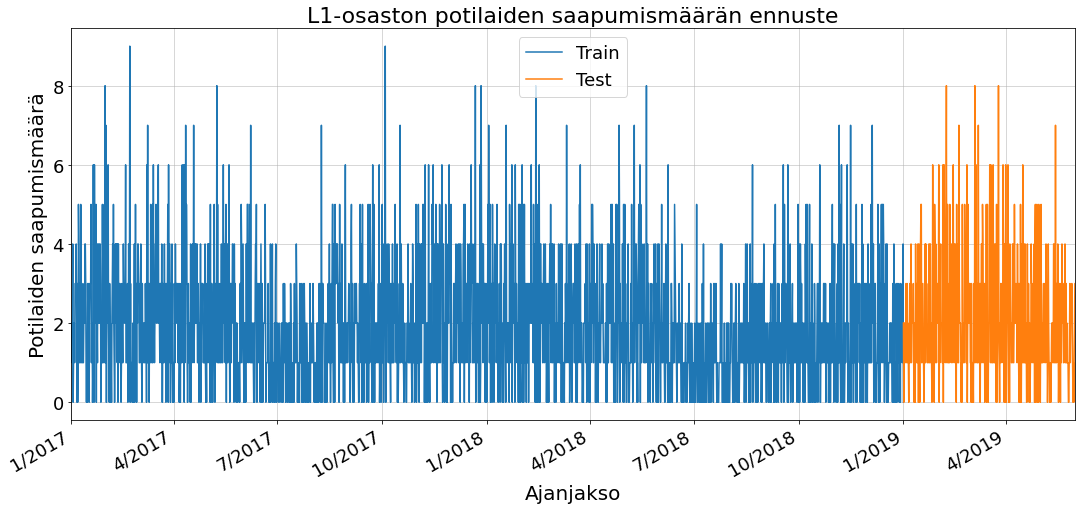

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(ward_train_8h.arrivals, ls='-', label='Train')
ax.plot(ward_test_8h.arrivals, ls='-', label='Test')
plt.rcParams.update({'font.size': 18})
ax.set_title('L1-osaston potilaiden saapumismäärän ennuste', fontsize=22)
ax.set_xlabel('Ajanjakso', fontsize=20)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

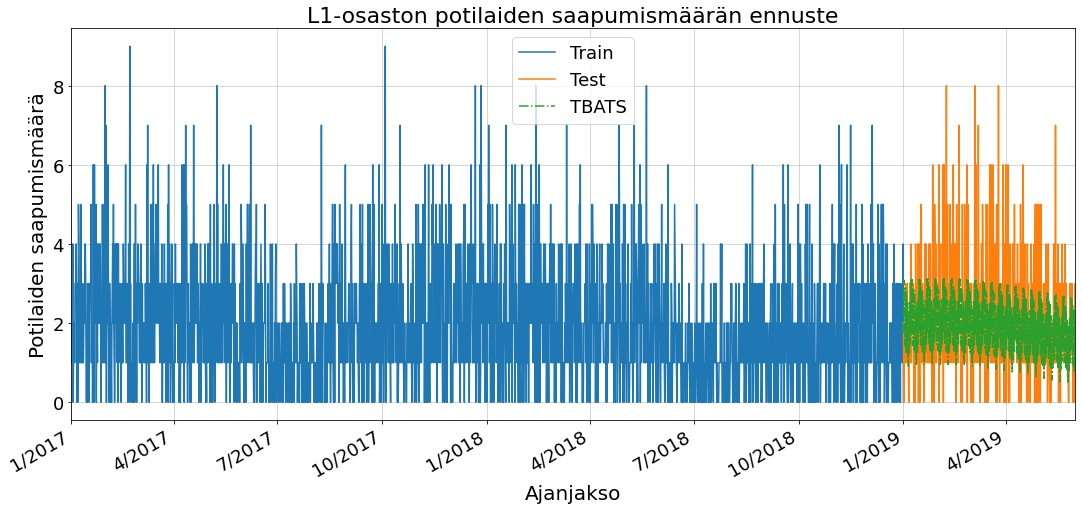

In [12]:
fig, ax = plt.subplots(figsize=(18, 8))
plt.rcParams.update({'font.size': 18})
ax.plot(ward_train_8h.arrivals, ls='-', label='Train')
ax.plot(ward_test_8h.arrivals, ls='-', label='Test')
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS')
ax.set_title('L1-osaston potilaiden saapumismäärän ennuste', fontsize=22)
plt.xlabel('Ajanjakso', fontsize=20)
plt.ylabel('Potilaiden saapumismäärä', fontsize=20)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019'], fontsize=18)
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

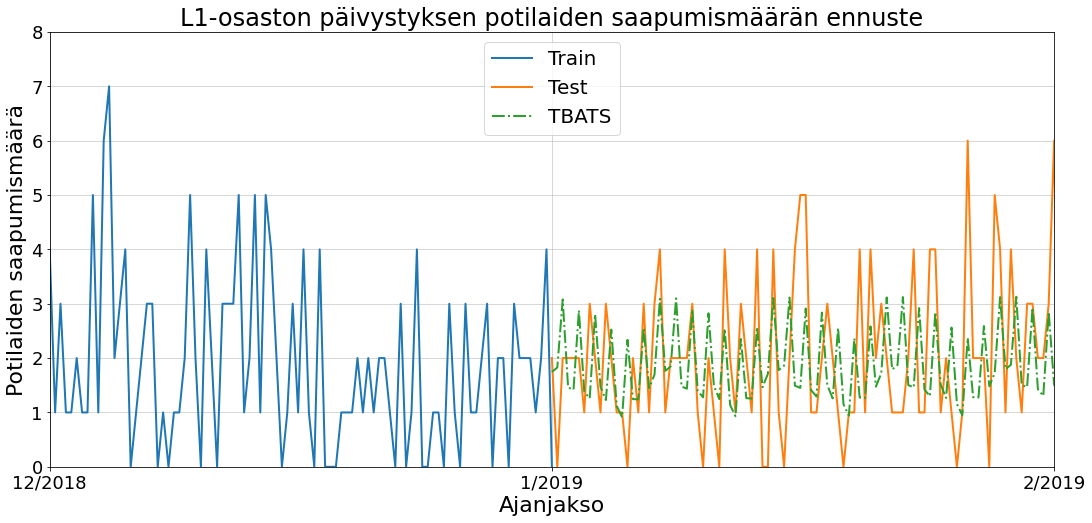

In [13]:
fig, ax = plt.subplots(figsize=(18, 8))
plt.rcParams.update({'font.size': 20})
ax.plot(ward_train_8h.arrivals, ls='-', label='Train', linewidth=2)
ax.plot(ward_test_8h.arrivals, ls='-', label='Test', linewidth=2)
ax.plot(additive.ennuste_TBATS, ls='-.', label='TBATS', linewidth=2)
ax.set_title('L1-osaston päivystyksen potilaiden saapumismäärän ennuste', fontsize=24)
plt.xlabel('Ajanjakso', fontsize=22)
plt.ylabel('Potilaiden saapumismäärä', fontsize=22)
ax.legend(loc='upper center')
plt.margins(x=0)
plt.xticks([pd.Timestamp('2018-12-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-02-01')], ['12/2018', '1/2019', '2/2019'])
plt.grid(linewidth=0.5)
plt.ylim([0, 8])
plt.xlim([pd.Timestamp('2018-12-01'), pd.Timestamp('2019-02-01')])
plt.show()

In [14]:
aika = train_test_8h
span_day = pd.DataFrame(data={'time':[aika + timedelta(hours=x) for x in range(0, 8768, 8)]})
timestamp_day = [aika + timedelta(hours=x) for x in range(0, 8760, 8)]
year_test_8h = pd.DataFrame(data={'time':timestamp_day})
year_test_8h['timespan'] = pd.arrays.IntervalArray.from_arrays(left = span_day['time'][0:-1], right = span_day['time'][1:], closed='left')
year_test_8h['arrivals'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).contains(b) for b in ward_test['alkuhetki']]).sum()
year_test_8h['departments'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).contains(b) for b in ward_test['loppuhetki']]).sum()
year_test_8h['patient_count'] = pd.DataFrame([pd.arrays.IntervalArray(year_test_8h['timespan']).overlaps(b) for b in ward_test['aikaväli']]).sum()
year_test_8h.set_index('time', inplace=True)
year_test_8h.head()

,timespan,arrivals,departments,patient_count
time,,,,
2019-01-01 00:00:00,"[2019-01-01, 2019-01-01 08:00:00)",2,0,2
2019-01-01 08:00:00,"[2019-01-01 08:00:00, 2019-01-01 16:00:00)",0,0,2
2019-01-01 16:00:00,"[2019-01-01 16:00:00, 2019-01-02)",2,1,4
2019-01-02 00:00:00,"[2019-01-02, 2019-01-02 08:00:00)",2,0,5
2019-01-02 08:00:00,"[2019-01-02 08:00:00, 2019-01-02 16:00:00)",2,2,7


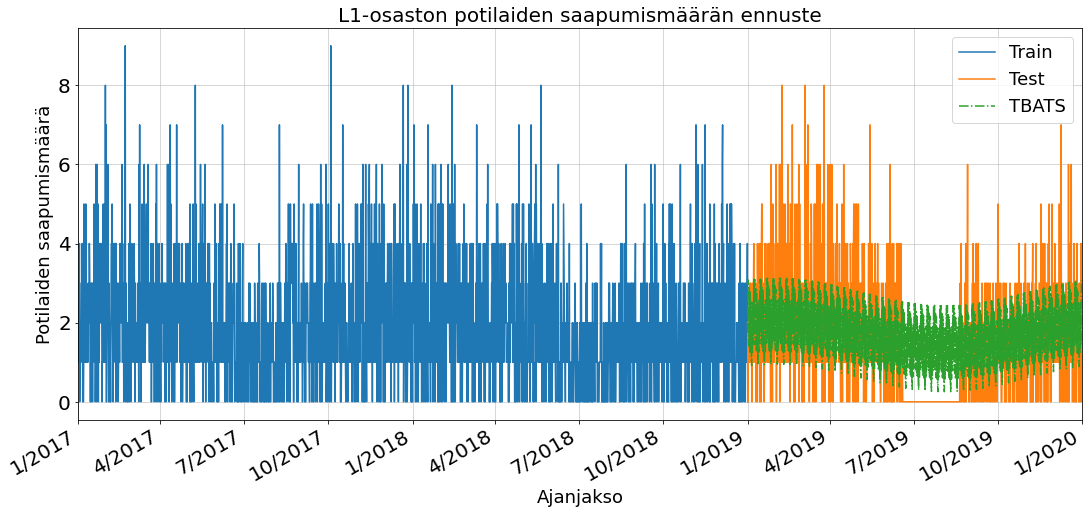

In [15]:
new_index = pd.date_range("2019-01-01", "2019-12-31", freq='8H')
year_pred = pd.DataFrame(np.nan, index=new_index[:-1], columns=ward_train_8h.columns)
year_pred.timespan = pd.arrays.IntervalArray.from_arrays(left = new_index[:-1], right = new_index[1:], closed='left')
year_pred['TBATS'] = tbats.forecast(steps=1092)

fig, ax = plt.subplots(figsize=(18, 8))
plt.rcParams.update({'font.size': 18})
ax.plot(ward_train_8h.arrivals, ls='-', label='Train')
ax.plot(year_test_8h.arrivals, ls='-', label='Test')
ax.plot(year_pred.TBATS, ls='-.', label='TBATS')
ax.set_title('L1-osaston potilaiden saapumismäärän ennuste', fontsize=20)
ax.set_xlabel('Ajanjakso', fontsize=18)
ax.set_ylabel('Potilaiden saapumismäärä', fontsize=18)
ax.legend(loc='best')
fig.autofmt_xdate()
plt.xticks([pd.Timestamp('2017-01-01'), pd.Timestamp('2017-04-01'), pd.Timestamp('2017-07-01'), pd.Timestamp('2017-10-01'), pd.Timestamp('2018-01-01'), pd.Timestamp('2018-04-01'), pd.Timestamp('2018-07-01'), pd.Timestamp('2018-10-01'), pd.Timestamp('2019-01-01'), pd.Timestamp('2019-04-01'), pd.Timestamp('2019-07-01'), pd.Timestamp('2019-10-01'), pd.Timestamp('2019-12-31')], ['1/2017', '4/2017', '7/2017', '10/2017', '1/2018', '4/2018', '7/2018', '10/2018', '1/2019', '4/2019', '7/2019', '10/2019', '1/2020'])
plt.margins(x=0)
plt.grid(linewidth=0.5)
plt.show()

In [16]:
#pickle.dump(tbats, open('tbats_L1_2017-2019-triple_final.pkl', 'wb'))

In [17]:
def sym_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred))/2)) * 100

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean(np.power((y_true - y_pred), 2))

## Tulokset
### Viiden kuukauden ennuste

In [18]:
y_pred = additive.ennuste_TBATS
smape = sym_mean_absolute_percentage_error(ward_test_8h.arrivals, y_pred)
mae = mean_absolute_error(ward_test_8h.arrivals, y_pred)
mse = mean_squared_error(ward_test_8h.arrivals, y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 67.45645324432233
MAE TBATS: 1.1560684896213493
MSE TBATS: 2.3424273856758253
RMSE TBATS: 1.530499064251862


### 42 päivän ennuste

In [19]:
y_pred = additive.ennuste_TBATS[:126]
smape = sym_mean_absolute_percentage_error(ward_test_8h.arrivals[:126], y_pred)
mae = mean_absolute_error(ward_test_8h.arrivals[:126], y_pred)
mse = mean_squared_error(ward_test_8h.arrivals[:126], y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 62.56761925897426
MAE TBATS: 1.1790043180239724
MSE TBATS: 2.3037297518353697
RMSE TBATS: 1.5178042534646454


### 30 päivän ennuste

In [20]:
y_pred = additive.ennuste_TBATS[:90]
smape = sym_mean_absolute_percentage_error(ward_test_8h.arrivals[:90], y_pred)
mae = mean_absolute_error(ward_test_8h.arrivals[:90], y_pred)
mse = mean_squared_error(ward_test_8h.arrivals[:90], y_pred)
rmse = np.sqrt(mse)
print('SMAPE TBATS:', smape)
print('MAE TBATS:', mae)
print('MSE TBATS:', mse)
print('RMSE TBATS:', rmse)

SMAPE TBATS: 62.75424432241737
MAE TBATS: 1.0677458681066299
MSE TBATS: 1.7605302345391256
RMSE TBATS: 1.3268497407540636
